# Stacking (*with an example in `scikitlearn`*)

A common use case for distributed arrays is applying operations in parallel.

When we construct a distributed version of a 2D array, the inherent structure is for the values to be one-dimensional arrays. While this is useful and generic, for some applications it is preferable to `stack` the values into larger arrays that we can operate on in parallel.

## How to stack

To do this kind of stacking, you can call `stack` and just provide the target size

In [2]:
from bolt import ones

In [23]:
a = ones((100, 5), sc)

Without stacking each record is an array of shape `(5,)`

In [24]:
a.tordd().values().first().shape

(5,)

But once we stack, each record has shape `(5,5)`

In [25]:
a.stack(5).tordd().values().first().shape

(5, 5)

Note that the true shape itself hasn't changed

In [26]:
a.stack(5).shape

(100, 5)

We can perform `map` operations over the stacked array and then `unstack` and shape information is automatically propagated

In [27]:
a.stack(5).map(lambda x: x * 2).unstack().toarray().shape

(100, 5)

In [31]:
a.stack(5).map(lambda x: x.sum(axis=0)).unstack().toarray().shape

(20, 5)

## Use case with `scikit-learn`

As an example use case, we'll use `scikit-learn` to apply a model's `partial_fit` method in parallel

First, make the data

In [101]:
from sklearn import datasets
X, y = datasets.make_blobs(n_samples=500, random_state=8)

In [102]:
X.shape

(500, 2)

Construct our Bolt array

In [129]:
from bolt import array

In [130]:
b = array(X, sc)

In [131]:
b.shape

(500, 2)

Create our model

In [146]:
from sklearn.cluster import MiniBatchKMeans
km = MiniBatchKMeans(n_clusters=3)

And now call `partial_fit` on our stacked array

In [154]:
stacked = b.stack(10)
models = stacked.map(lambda x: km.partial_fit(x).cluster_centers_)
average = models.unstack().mean(axis=0)
centers = average.toarray()

Let's plot the result

In [137]:
centers

array([[ 7.63975025,  0.97063748],
       [-5.83396958, -9.81744661],
       [ 7.47702662,  9.80294156]])

In [138]:
%matplotlib inline

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

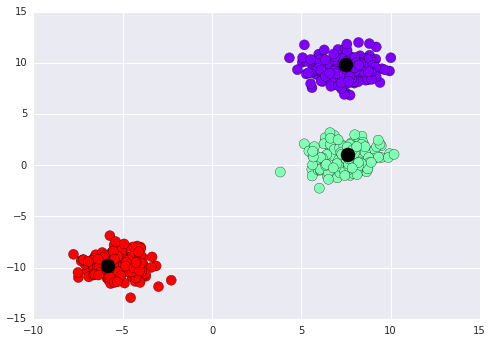

In [140]:
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap='rainbow');
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='black', cmap='rainbow');

NOTE: just because we're parallelizing doesn't mean we'll see a performance improvement! Among other factors, it will depend on the size of the data set, the size of the cluster, and the kind of operation. One of the goals of Bolt is to make it easy to switch between a local or distributed setting, and use whichever one is faster with minimal code changes.

In this case, we could easily switch to a local array

In [141]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)

In [155]:
model = km.fit(b.toarray())
centers = model.cluster_centers_

and hopefully get the same answer

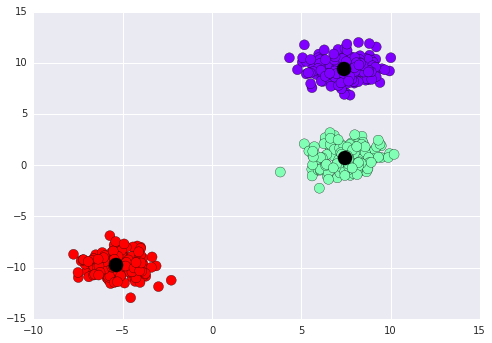

In [156]:
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap='rainbow');
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='black', cmap='rainbow');